In [1]:
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, sampler

import torchvision
from torchvision import datasets, models, transforms


import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import time
import os
import copy

plt.ion()   # interactive mode

## 一、数据处理与加载

### 1. 数据读入

In [2]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

In [30]:
# 这里懒得改代码了，之前读入之前的图片识别的数据集
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),

    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}


data_dir = 'D:/4.Data/CIFAR'

image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val', 'test']}

# 得到可batch的数据格式
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=False, num_workers=1)
               for x in ['train', 'val']}

testdataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=1)
                   for x in ['test']}


# 得到数据规模
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

# 得到分类名
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
train_data = dataloaders['train']

In [5]:
train_data.__iter__().next()[0].shape

torch.Size([4, 3, 32, 32])

### 2. 数据可视化

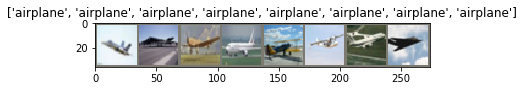

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:8]
# Make a grid from batc
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes[0:8]])

## 二、建立模型

DCGAN其实就是把网络结构换成了CNN

### 卷积判别网络
卷积判别网络就是一个一般的卷积网络，结构如下

* 16 Filters, 3x3, Stride 1, Padding 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 32 Filters, 3x3, Stride 1, Padding 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 3x3, Stride 1, Padding 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [34]:
class DCGAN_D(nn.Module):
    def __init__(self):
        super(DCGAN_D, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

### 卷积生成网络
卷积生成网络需要将一个低维的噪声向量变成一个图片数据，结构如下

* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Reshape into Image Tensor
* 64 conv2d^T filters of 4x4, stride 1, padding 1, ReLU
* BatchNorm
* 32 conv2d^T filters of 4x4, stride 2, padding 1, ReLU
* BatchNorm
* 3 conv2d^T filter of 4x4, stride 2, padding 1, TanH

In [35]:
class DCGAN_G(nn.Module):
    def __init__(self, noise_dim=NOISE_DIM):
        super(DCGAN_G, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )
        
        
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1),
            
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) 
        x = self.conv(x)
        return x

## 三、设置必要的参数

In [9]:
# 设置为GPU处理
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# 交叉熵
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(logits_real, logits_fake): # 判别器的 loss
    size = logits_real.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().to(device)
    false_labels = Variable(torch.zeros(size, 1)).float().to(device)
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss

In [11]:
def generator_loss(logits_fake): # 生成器的 loss  
    size = logits_fake.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().to(device)
    loss = bce_loss(logits_fake, true_labels)
    return loss

In [12]:
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

## 四、训练模型

In [36]:
def train_dc_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            
            bs = x.shape[0]
            # 判别网络
            real_data = Variable(x).to(device) # 真实数据
            logits_real = D_net(real_data) # 判别网络得分

            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).to(device)
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络
            
            # 生成网络
            g_fake_seed = Variable(sample_noise).to(device)
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.cpu().item(), g_error.cpu().item()))
                print(fake_images.shape)
                out = torchvision.utils.make_grid(fake_images.cpu()[0:8])
                imshow(out)

                plt.show()
                print()
            iter_count += 1

In [ ]:
D_DC = DCGAN_D().to(device)
G_DC = DCGAN_G().to(device)

D_DC_optim = get_optimizer(D_DC)
G_DC_optim = get_optimizer(G_DC)

Iter: 0, D: 0.1476, G:2.465
torch.Size([128, 3, 32, 32])


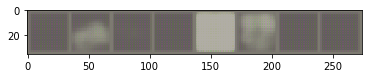


Iter: 250, D: 0.456, G:2.135
torch.Size([128, 3, 32, 32])


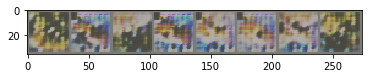


Iter: 500, D: 0.2336, G:2.704
torch.Size([128, 3, 32, 32])


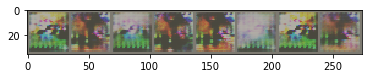


Iter: 750, D: 0.4504, G:2.208
torch.Size([128, 3, 32, 32])


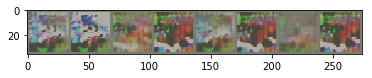


Iter: 1000, D: 0.1465, G:2.978
torch.Size([128, 3, 32, 32])


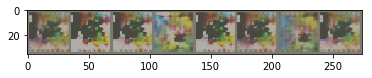


Iter: 1250, D: 0.07977, G:3.776
torch.Size([128, 3, 32, 32])


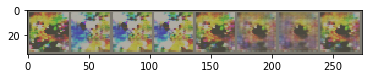


Iter: 1500, D: 0.3079, G:4.457
torch.Size([128, 3, 32, 32])


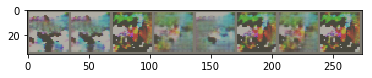


Iter: 1750, D: 0.07364, G:3.898
torch.Size([128, 3, 32, 32])


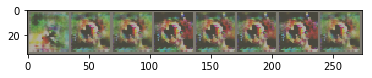


Iter: 2000, D: 0.05537, G:4.38
torch.Size([128, 3, 32, 32])


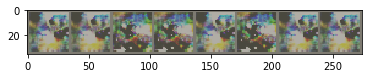


Iter: 2250, D: 0.3198, G:2.714
torch.Size([128, 3, 32, 32])


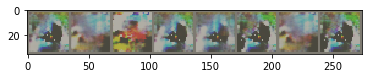


Iter: 2500, D: 0.116, G:3.272
torch.Size([128, 3, 32, 32])


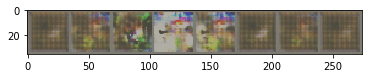


Iter: 2750, D: 0.06213, G:4.334
torch.Size([128, 3, 32, 32])


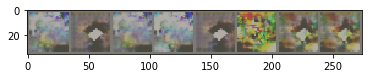


Iter: 3000, D: 0.2271, G:4.561
torch.Size([128, 3, 32, 32])


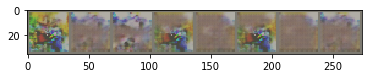


Iter: 3250, D: 0.02287, G:4.938
torch.Size([128, 3, 32, 32])


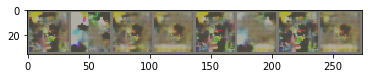


Iter: 3500, D: 0.03389, G:4.557
torch.Size([128, 3, 32, 32])


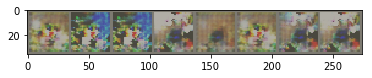


Iter: 3750, D: 0.2149, G:5.748
torch.Size([128, 3, 32, 32])


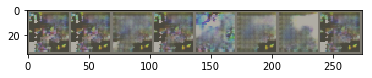


Iter: 4000, D: 0.03717, G:4.777
torch.Size([128, 3, 32, 32])


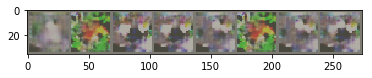


Iter: 4250, D: 0.01592, G:4.956
torch.Size([128, 3, 32, 32])


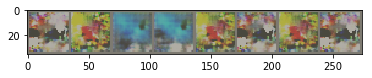


Iter: 4500, D: 0.2071, G:6.141
torch.Size([128, 3, 32, 32])


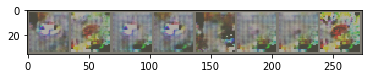


Iter: 4750, D: 0.01128, G:5.271
torch.Size([128, 3, 32, 32])


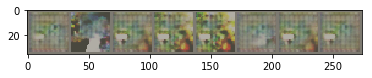


Iter: 5000, D: 0.04693, G:4.019
torch.Size([128, 3, 32, 32])


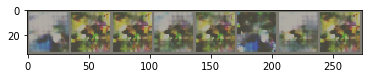


Iter: 5250, D: 0.1782, G:6.116
torch.Size([128, 3, 32, 32])


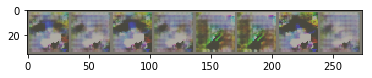


Iter: 5500, D: 0.007543, G:5.282
torch.Size([128, 3, 32, 32])


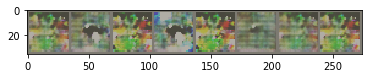


Iter: 5750, D: 0.01634, G:5.075
torch.Size([128, 3, 32, 32])


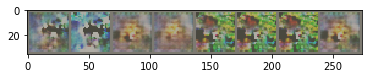


Iter: 6000, D: 0.08378, G:6.894
torch.Size([128, 3, 32, 32])


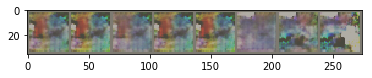


Iter: 6250, D: 0.02463, G:4.876
torch.Size([128, 3, 32, 32])


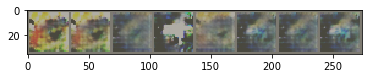


Iter: 6500, D: 0.006066, G:5.597
torch.Size([128, 3, 32, 32])


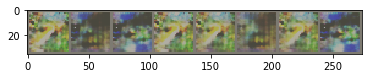


Iter: 6750, D: 0.1104, G:6.835
torch.Size([128, 3, 32, 32])


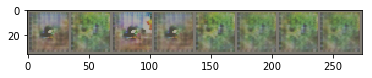


Iter: 7000, D: 0.00687, G:5.533
torch.Size([128, 3, 32, 32])


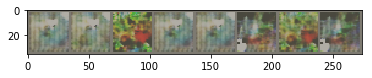


Iter: 7250, D: 0.003939, G:5.747
torch.Size([128, 3, 32, 32])


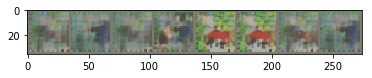


Iter: 7500, D: 0.1397, G:6.19
torch.Size([128, 3, 32, 32])


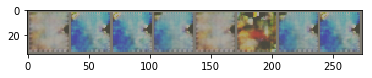


Iter: 7750, D: 0.01059, G:5.212
torch.Size([128, 3, 32, 32])


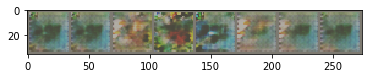


Iter: 8000, D: 0.007556, G:5.736
torch.Size([128, 3, 32, 32])


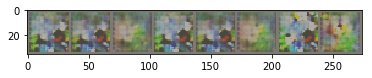


Iter: 8250, D: 0.07921, G:6.491
torch.Size([128, 3, 32, 32])


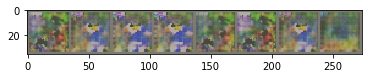


Iter: 8500, D: 0.007241, G:5.337
torch.Size([128, 3, 32, 32])


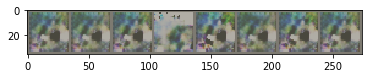


Iter: 8750, D: 0.004061, G:5.663
torch.Size([128, 3, 32, 32])


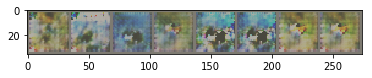


Iter: 9000, D: 0.06575, G:6.731
torch.Size([128, 3, 32, 32])


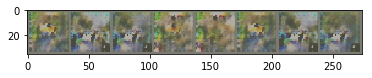


Iter: 9250, D: 0.02501, G:4.803
torch.Size([128, 3, 32, 32])


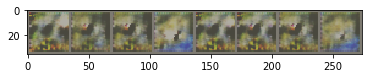

In [39]:
train_dc_gan(D_DC, G_DC, D_DC_optim, G_DC_optim, discriminator_loss, generator_loss, num_epochs=25)
